---
title: "Identificando desastres en Twitter con NLP: Neural Network"
image: "disaster.jpeg"
author: "Diegulio"
format: 
  html:
    code-fold: false
jupyter: python3
---

# Simple NN
In this notebook I will use a simple Neural Network Arquitecture. We need to remember that we only can feed numbers to NN !

The Arquitecture will look like this:

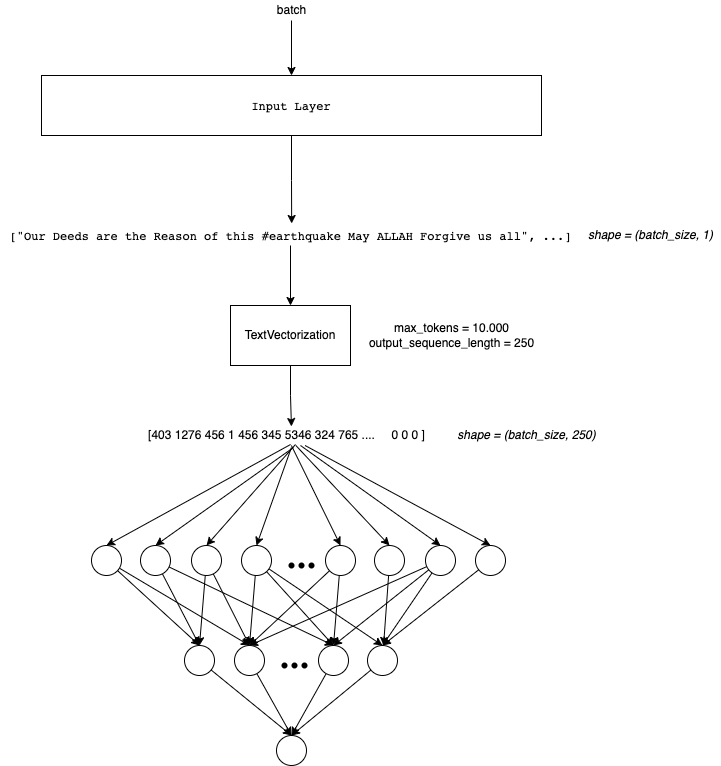

Remember that is belong to a NLP Notebook series where I am learning and testing different NLP approachs in this competition. Like NN, Embedding, RNN, Transformers, HuggingFace, etc.

To see the other notebooks visit: https://www.kaggle.com/code/diegomachado/seqclass-nn-embed-rnn-lstm-gru-bert-hf

## Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import gc


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Lambda
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow_hub as hub
#import tensorflow_text as text # Bert preprocess uses this 
from tensorflow.keras.optimizers import Adam

import re
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors

#nltk.download('stopwords')

## Data

In [2]:
# Load data
train = pd.read_csv("/kaggle/input/df-split/df_split/df_train.csv")
test = pd.read_csv("/kaggle/input/df-split/df_split/df_test.csv")

X_train = train[[col for col in train.columns if col != 'target']].copy()
y_train = train['target'].copy()

X_test = test[[col for col in test.columns if col != 'target']].copy()
y_test = test['target'].copy()


In [3]:
# Tensorflow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train.text, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test.text, y_test))
train_ds

2022-12-11 14:55:06.219408: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

Instantiate [TextVectorization Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)


In [4]:
max_features = 10000 # Vocabulary (TensorFlow select the most frequent tokens)
sequence_length = 50 # It will pad or truncate sequences
vectorization_layer = TextVectorization(
    max_tokens = max_features,
    output_sequence_length = sequence_length,
)

# Adapt is to compute metrics (In this case the vocabulary)
vectorization_layer.adapt(X_train.text)

2022-12-11 14:55:06.451771: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
# Testing the Vectorization layer
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorization_layer(text)

# retrieve a batch (of 1 review and label) from the dataset
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch, label_batch
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review))

Review tf.Tensor(b'Riot Kit Bah - part of the new concept Gear coming for Autumn/Winter\n#menswear #fashion #urbanfashion\xc2\x89\xc3\x9b_ https://t.co/cCwzDTFbUS', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int64)
Vectorized review tf.Tensor(
[[ 403 1278    1  572    6    2   44 3700    1  250   10    1    1  968
  6559    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)


**🔍** We see that the length of the vector is `output_sequence_length = 250`, and if the statement is not that long, it is paded with 0. We also note that no integer is greater than 10000, since we set this as our maximum vocabulary of tokens (vocabulary_size()). We also see that there are some integers = 1. This in the vocabulary corresponds to `UNK`, that is, unknown words (tokens), this is because our vocabulary is limited (TextVectorization chooses the 10000 most frequent ones).

An improvement can be to analyze the length of the dataset sentences and choose an output_sequence_lenght based on this (to avoid to much pad)

In [6]:
vectorization_layer.vocabulary_size()

10000

In [7]:
# To see the vocabulary
vectorization_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

### Data Pipeline

Now we need to prepare the data pipeline:

batch -> cache -> prefetch

- `Batch` : Create a set of samples (Those will be processed together in the model)
- `Cache`: The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.
- `Prefetch` : This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

Optional: You can do it another steps like `shuffle`

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

### Model 

We will build a simple Sequential Model composed by two Dense Layers. I dont take to much time tunning it.

In [9]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string), # Input Layer
    vectorization_layer, # Vectorization Layer
    layers.Dense(64),
    #layers.Dropout(0.1),
    layers.Dense(32),
    #layers.Dropout(0.1),
    layers.Dense(1)
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


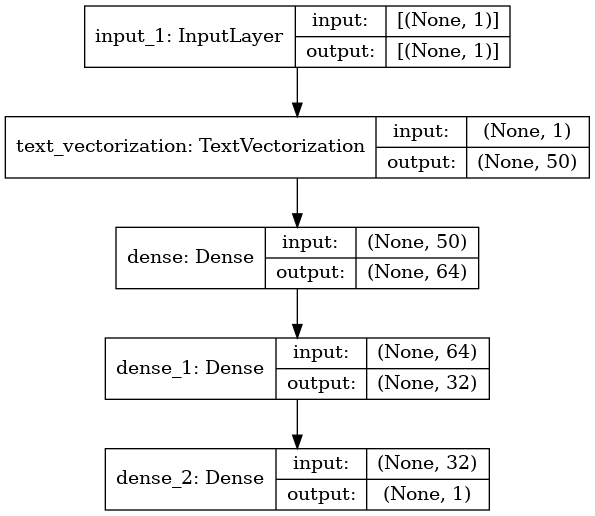

In [11]:
plot_model(model, show_shapes=True)

In [12]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

🔍 **Due to our last Dense Layer has a linear activation function, it computes the logits. So the loss function needs to be computed with `from_logits=True`.**

In [13]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=epochs)

Epoch 1/100
191/191 [==============================] - 2s 4ms/step - loss: 76.1297 - binary_accuracy: 0.5123 - val_loss: 30.4719 - val_binary_accuracy: 0.5207
Epoch 2/100
191/191 [==============================] - 1s 3ms/step - loss: 37.2703 - binary_accuracy: 0.5167 - val_loss: 22.0519 - val_binary_accuracy: 0.5194
Epoch 3/100
191/191 [==============================] - 1s 3ms/step - loss: 34.7663 - binary_accuracy: 0.5118 - val_loss: 27.2791 - val_binary_accuracy: 0.5141
Epoch 4/100
191/191 [==============================] - 1s 3ms/step - loss: 28.8605 - binary_accuracy: 0.5135 - val_loss: 26.1287 - val_binary_accuracy: 0.5253
Epoch 5/100
191/191 [==============================] - 1s 3ms/step - loss: 28.4162 - binary_accuracy: 0.5123 - val_loss: 24.3497 - val_binary_accuracy: 0.5108
Epoch 6/100
191/191 [==============================] - 1s 3ms/step - loss: 26.5699 - binary_accuracy: 0.5084 - val_loss: 17.0479 - val_binary_accuracy: 0.5148
Epoch 7/100
191/191 [=========================

### Pred test
Now we will predict the test to do the submission

In [14]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [15]:
topred_ds = tf.data.Dataset.from_tensor_slices(test_df.text)
AUTOTUNE = tf.data.AUTOTUNE
topred_ds = topred_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
preds = model.predict(topred_ds)

In [17]:
preds

array([[-0.83098686],
       [-0.71497   ],
       [-0.4031287 ],
       ...,
       [-0.3488861 ],
       [-0.4957207 ],
       [-1.3229517 ]], dtype=float32)

📝 **Note that those are the logits**! 

To get a prediction we will compute the sigmoid function and round it to 1 or 0! (Thats because they are 2 classes, if there would be multi class classification then we would need Softmax Function)

In [18]:
test_df["target"] = tf.round(tf.nn.sigmoid(preds)) # We use simple round function
test_df["target"] = test_df["target"].astype(int) # Submission needs int prediction

In [19]:
test_df.target.value_counts()

0    3023
1     240
Name: target, dtype: int64

In [20]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [21]:
#sub.to_csv("NN_submission.csv", index = False)
sub.to_csv("submission.csv", index = False)

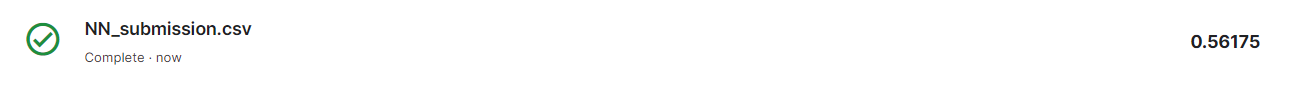

# Conclussions

🦾 **It is very bad but it is a baseline! It is a little better than predicting at random **

Here we are using an Integer Embedding to represent text. It is not efficient because:
1. It doesnt Capture relationship between tokens
2. Frequently each token has a weight. In this case each token could appear in any place of the generated sequence. So multiple tokens will share weights! But they mean different context!

I think using an Embedding Layer will improve the results! Lets do it in the next notebook!



# Anyway, it should serve as motivation to keep improving! 